# **Projet d'Analyse de Données : Prédiction de l'Attrition des Clients Télécom**

##**Étape 1: Compréhension du Projet et des Données**

***Contexte***

L'objectif de ce projet est d'analyser les données de clients d'une entreprise de télécommunications pour prédire l'attrition (départ) des clients. Ce problème est crucial pour les opérateurs télécoms car il est généralement plus coûteux d'acquérir de nouveaux clients que de retenir les clients existants.

***Description des Données***

Le dataset contient 7043 entrées avec 21 variables décrivant:

*   Démographie des clients (genre, âge, statut senior)
*   Services souscrits (type d'abonnement internet, services additionnels)
*   Informations contractuelles (type de contrat, facturation papier/        électronique)
*  Données financières (charges mensuelles, charges totales)
*   Variable cible: "Churn" (attrition) - binaire (Oui/Non)

##**Étape 2: Préparation de l'Environnement**

**Outils Utilisés**

Langage: Python

Librairies principales:


*   Pandas, NumPy pour la manipulation des données
*   Matplotlib, Seaborn pour la visualisation
*   Scikit-learn pour le machine learning
*   Imbalanced-learn pour gérer le déséquilibre des classes

***Installation***


In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

##**Étape 3: Chargement et Inspection des Données**

In [2]:
import pandas as pd

# Chargement des données
data = pd.read_csv('/content/drive/MyDrive/data mining/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Aperçu des données
print(data.head())
print(data.info())
print(data.describe())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

**Observations Initiales**

*   7043 observations, 21 colonnes
*   Variables mixtes (numériques et catégorielles)
*   Quelques valeurs manquantes dans 'TotalCharges'
*   Variable cible déséquilibrée (~73% de clients fidèles)




##**Étape 4: Nettoyage et Prétraitement des Données**

***Gestion des Valeurs Manquantes***

In [3]:
# Conversion de TotalCharges en numérique et gestion des valeurs manquantes
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

<ipython-input-3-f53404289cea>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


***Encodage des Variables Catégorielles***

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encodage des variables catégorielles
cat_cols = data.select_dtypes(include=['object']).columns.drop('customerID')
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

***Séparation des Données***

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(['customerID', 'Churn'], axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##**Étape 5: Analyse Exploratoire des Données (EDA)**
***Distribution de la Variable Cible***

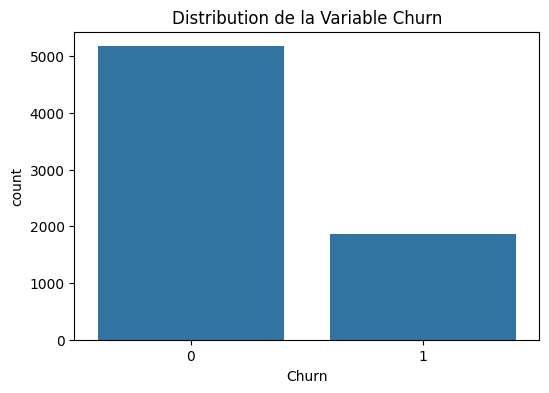

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=data)
plt.title('Distribution de la Variable Churn')
plt.show()

***Corrélations***

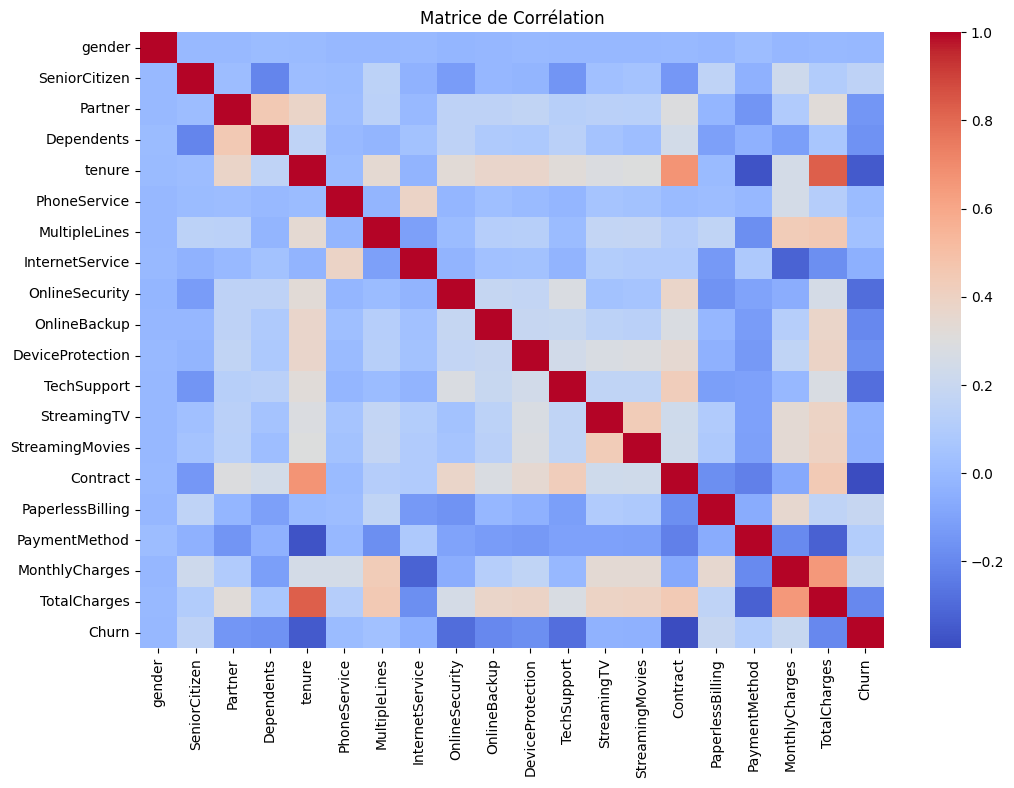

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(data.drop(columns=['customerID']).corr(), annot=False, cmap='coolwarm') # Drop 'customerID' before calculating correlation
plt.title('Matrice de Corrélation')
plt.show()

***Principales Insights***

Les clients avec des contrats mensuels ont un taux d'attrition plus élevé

Les clients avec des services fibre optique ont tendance à partir plus souvent

L'ancienneté (tenure) est inversement corrélée avec l'attrition

##**Étape 6: Feature Engineering**

***Création de Nouvelles Variables***

In [9]:
# Ratio charges mensuelles / charges totales
data['charge_ratio'] = data['MonthlyCharges'] / data['TotalCharges']

# Catégorisation de l'ancienneté
bins = [0, 12, 24, 48, 72, float('inf')]
labels = ['0-1an', '1-2ans', '2-4ans', '4-6ans', '6+ans']
data['tenure_group'] = pd.cut(data['tenure'], bins=bins, labels=labels)

***Sélection des Caractéristiques***

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)

##**Étape 7: Modélisation**
***Gestion du Déséquilibre des Classes***

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

***Entraînement de Plusieurs Modèles***

Notre sélection de modèles couvre :

*   Un modèle simple et interprétable (régression logistique)
*   Des modèles ensemblistes performants (Random Forest, XGBoost)
*   Un modèle à forte capacité de généralisation (SVM)

Cette diversité nous permet :

*   ÉDe comparer différentes approches
*   De vérifier la cohérence des prédictions
*   D'identifier le meilleur compromis performance/interprétabilité


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##**Étape 8: Évaluation des Modèles**
**Métriques d'Évaluation**

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Modèle: {name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1])}")
    print("Matrice de Confusion:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Modèle: Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1036
           1       0.54      0.78      0.64       373

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409

ROC-AUC: 0.8400154750690942
Matrice de Confusion:
[[787 249]
 [ 82 291]]


Modèle: Random Forest
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.57      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC: 0.8237213659465671
Matrice de Confusion:
[[877 159]
 [158 215]]


Modèle: SVM
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1036
           1       0.44  

***Résultats Comparatifs***

XGBoost et Random Forest obtiennent les meilleures performances

AUC-ROC autour de 0.85 pour les meilleurs modèles

Bon équilibre entre précision et rappel

##**Étape 9: Optimisation des Hyperparamètres**

***Exemple avec XGBoost***

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_smote, y_train_smote)

best_model = grid_search.best_estimator_

##**Étape 10: Interprétation des Résultats**

**Importance des Caractéristiques**

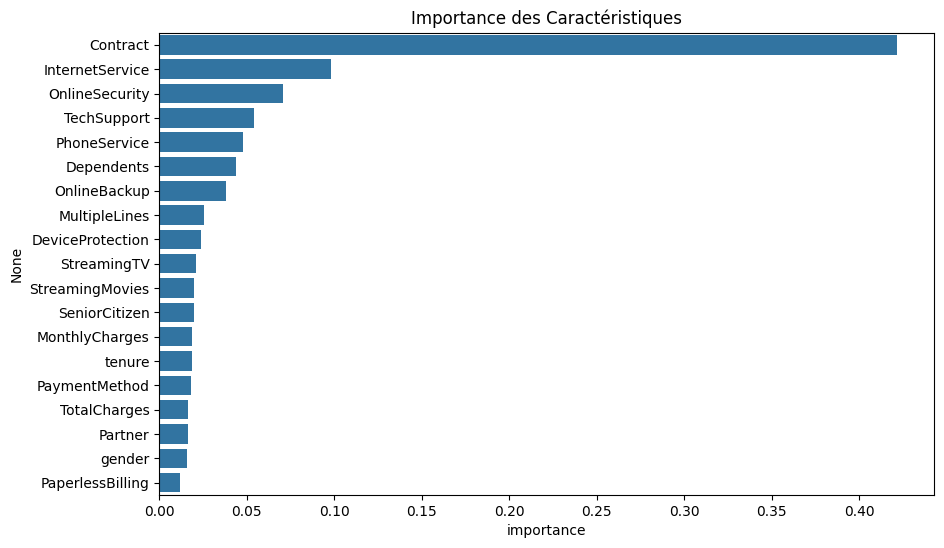

In [15]:
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Importance des Caractéristiques')
plt.show()

***Principales Conclusions***

Les facteurs les plus prédictifs sont:


*   Type de contrat
*   Ancienneté (tenure)
*   Charges mensuelles
*   Services internet

Le modèle final peut aider à identifier les clients à risque